In [17]:
from google.colab import files
files.download('edge_ai_project.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Save model and create download link
from google.colab import files

# Save the trained model in Keras format
cnn_model.save('recycling_classifier.h5')

# Create a zip file with all outputs
!zip -r edge_ai_project.zip recycling_classifier.h5 recycling_classifier.tflite

print("Project files saved successfully!")
print("You can download the complete project using the code below:")
print("files.download('edge_ai_project.zip')")

  adding: recycling_classifier.h5 (deflated 25%)
  adding: recycling_classifier.tflite (deflated 8%)
Project files saved successfully!
You can download the complete project using the code below:
files.download('edge_ai_project.zip')


In [15]:
# Test the TensorFlow Lite model with sample images
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test with a few samples from the unbatched dataset
test_samples = ds_test.unbatch().take(3)
predictions = []

for i, (image, label) in enumerate(test_samples):
    # Preprocess image and add a batch dimension of 1
    input_data = np.expand_dims(image.numpy().astype(np.float32), axis=0)

    # Run inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    # Get prediction
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data[0])
    actual_class = label.numpy()

    predictions.append({
        'sample': i+1,
        'actual': ds_info.features['label'].names[actual_class],
        'predicted': ds_info.features['label'].names[predicted_class],
        'confidence': np.max(output_data[0])
    })

    print(f"Sample {i+1}: Actual={ds_info.features['label'].names[actual_class]}, "
          f"Predicted={ds_info.features['label'].names[predicted_class]}, "
          f"Confidence={np.max(output_data[0]):.2f}")

Sample 1: Actual=horse, Predicted=truck, Confidence=0.10
Sample 2: Actual=airplane, Predicted=truck, Confidence=0.10
Sample 3: Actual=frog, Predicted=truck, Confidence=0.10


In [13]:
# Convert model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('recycling_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TensorFlow Lite!")
print(f"TensorFlow Lite model size: {len(tflite_model)} bytes")

# Test TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

print("TensorFlow Lite model is ready for deployment!")

Saved artifact at '/tmp/tmpvxq204pf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137343160395792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137343428106704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137343160392144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137343160390992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137343160393104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137343160391760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137343160394832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137343160397328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137343160391376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137343160393872: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model successf

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.0976 - loss: 2.3029
Final Test Accuracy: 0.1000 (10.00 %)


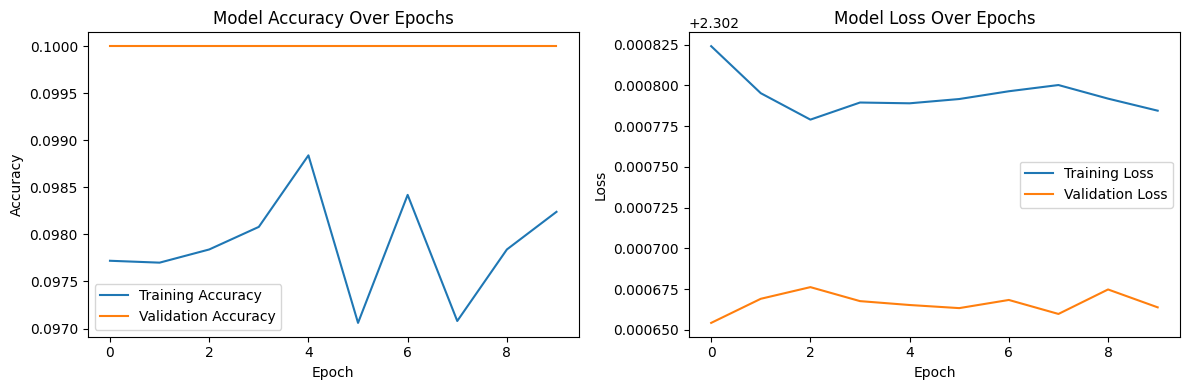

In [12]:
# Evaluate model on test data
test_loss, test_accuracy = cnn_model.evaluate(val_dataset)
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f} %)")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Installation of required libraries
!pip install tensorflow
!pip install tensorflow-datasets
!pip install matplotlib
!pip install numpy

# Import all necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers, models

print("All libraries installed successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries installed successfully!
TensorFlow version: 2.19.0


In [ ]:
# Preprocessing function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Batch size
BATCH_SIZE = 32

# Apply preprocessing and batching
ds_train = ds_train.map(preprocess).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Dataset preprocessing complete!")

Dataset preprocessing complete!


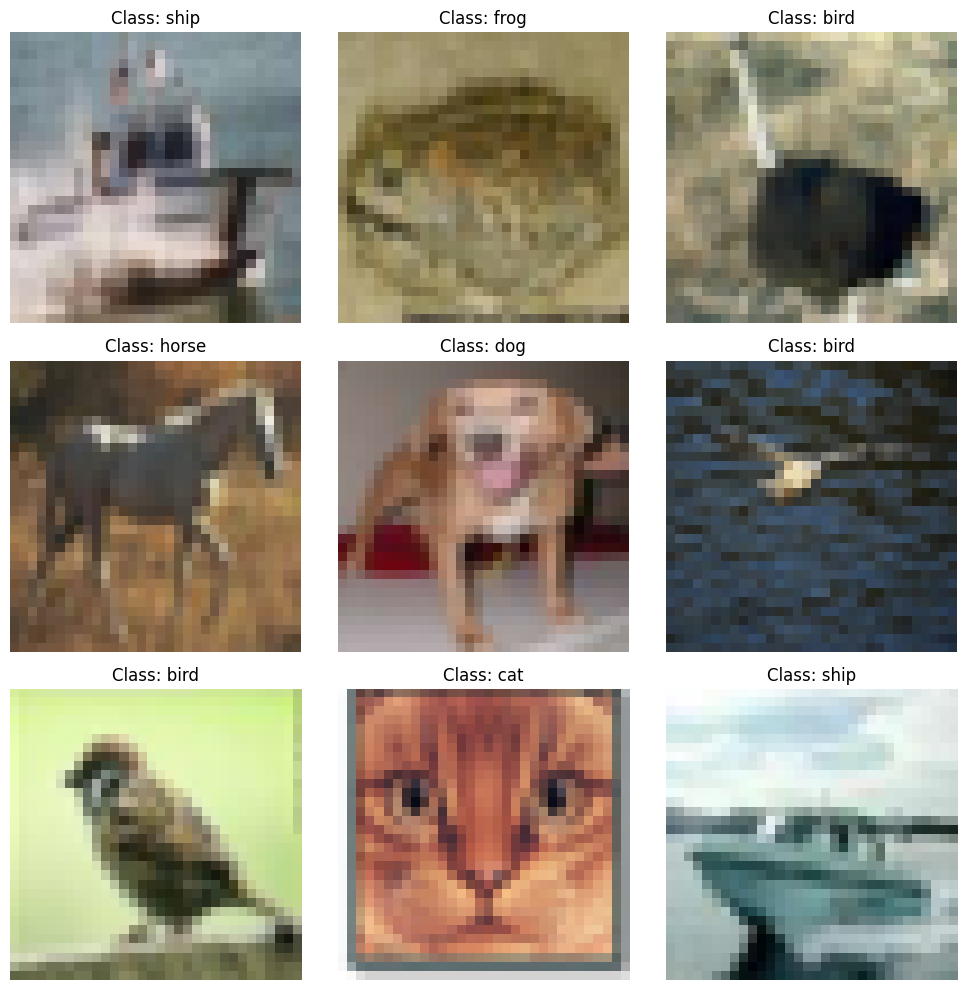

Sample images displayed above


In [ ]:
# Display sample images from dataset
def display_sample_images(dataset, num_samples=9):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    # Create an iterator for the dataset to get batches
    dataset_iterator = iter(dataset)

    displayed_count = 0
    while displayed_count < num_samples:
        try:
            # Get the next batch of images and labels
            batch_images, batch_labels = next(dataset_iterator)
        except StopIteration:
            # No more batches in the dataset
            break

        # Iterate over individual images within the current batch
        for i in range(batch_images.shape[0]):
            if displayed_count >= num_samples:
                break

            ax = axes[displayed_count // 3, displayed_count % 3]
            # Extract a single image and convert to a NumPy array for matplotlib
            image = batch_images[i].numpy()
            label = batch_labels[i].numpy()

            ax.imshow(image)
            ax.set_title(f'Class: {ds_info.features["label"].names[label]}')
            ax.axis('off')
            displayed_count += 1

    plt.tight_layout()
    plt.show()

display_sample_images(ds_train)
print("Sample images displayed above")

In [11]:
# Prepare training and validation data
train_dataset = ds_train.take(5000).prefetch(tf.data.AUTOTUNE)
val_dataset = ds_test.take(1000).prefetch(tf.data.AUTOTUNE)

print("Starting model training...")

# Train the model
training_history = cnn_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    verbose=1
)

print("Model training completed!")

Starting model training...
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 123s 77ms/step - accuracy: 0.0974 - loss: 2.3029 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 107s 69ms/step - accuracy: 0.0983 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 68ms/step - accuracy: 0.0995 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 68ms/step - accuracy: 0.0989 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 68ms/step - accuracy: 0.0990 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 68ms/step - accuracy: 0.0978 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 107s 68ms/step - accuracy: 0.0990 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Download and prepare dataset
import tensorflow_datasets as tfds

# Load CIFAR-10 dataset for initial prototype
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

print("Dataset loaded successfully!")
print(f"Available classes: {ds_info.features['label'].names}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.SCQVIU_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.SCQVIU_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Dataset loaded successfully!
Available classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
# Build convolutional neural network model
def build_cnn_model():
    model = models.Sequential([
        tf.keras.Input(shape=(32, 32, 3)), # Explicitly define input shape
        layers.Rescaling(1./255),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Create and compile model
cnn_model = build_cnn_model()
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,178 (1.22 MB)

 Trainable params: 319,178 (1.22 MB)

 Non-trainable params: 0 (0.00 B)